In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib import rcParams

# 设置字体
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Microsoft Yahei'

# 设置公式字体
config = {
    "mathtext.fontset": 'stix',
}
rcParams.update(config)


np.random.seed(42)
random.seed(42)


df = pd.read_csv('./data/分子描述符精神活性预测清理后模型数据集（总）.csv')
df_subset = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
# 删除包含 NaN 的行
df = df[~df_subset.isna().any(axis=1)]
# 删除smiles内容重复的行
df = df.drop_duplicates(subset=['smiles'])
# 选取0和1相同数量的type
df_0 = df[df['type'] == 0].sample(n=2000, random_state=42)
df_1 = df[df['type'] == 1].sample(n=2000, random_state=42)
# 合并两个 DataFrame
df = pd.concat([df_0, df_1]).reset_index(drop=True)

print(df.shape)
# smiles:为化学结构式
# type: 二分类
df_values = df[df.columns[2:]]
print(df_values.shape)
classify_results = df['type']
# 样本分布统计
unique, counts = np.unique(classify_results, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

X_vectors = df_values.to_numpy()
print(X_vectors.shape)
y_vectors = np.array(classify_results)

C:\Users\leisaihua\AppData\Local\Temp\ipykernel_4844\819959116.py:25: DtypeWarning: Columns (663,1411) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/分子描述符精神活性预测清理后模型数据集（总）.csv')


(4000, 1446)
(4000, 1444)
{np.int64(0): np.int64(2000), np.int64(1): np.int64(2000)}
(4000, 1444)


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# 计算准确率 Precision, Recall, F1, AUC
def get_results(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)  # 计算 AUC-ROC
    # 打印各项指标
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# X_vectors 是特征数据，y_vectors 是标签数据
X_train, X_test, y_train, y_test = train_test_split(X_vectors, y_vectors, test_size=0.2, random_state=42)
plot_PCA_train = X_train

# Z-score 标准化，使数据服从均值为0、方差为1的正态分布
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 在训练集上拟合标准化器并转换训练集
X_test_scaled = scaler.transform(X_test)        # 使用训练集的标准化器转换测试集

# 定义一个函数，用于确定保留的主成分数量（例如解释95%方差）
def get_dimension_by_PCA(X, variance_threshold=0.95):
    pca = PCA()
    pca.fit(X)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    return n_components

# 获取保留的主成分数量
value_95 = get_dimension_by_PCA(X_train_scaled)
print(f"Number of components to retain 95% variance: {value_95}")

# 使用保留的主成分数量拟合PCA模型
pca = PCA(n_components=value_95)
X_train_reduced = pca.fit_transform(X_train_scaled)  # 在训练集上拟合PCA并转换训练集
X_test_reduced = pca.transform(X_test_scaled)        # 使用训练集的PCA模型转换测试集

# 更新训练集和测试集
X_train = X_train_reduced
X_test = X_test_reduced

Number of components to retain 95% variance: 123


78 123


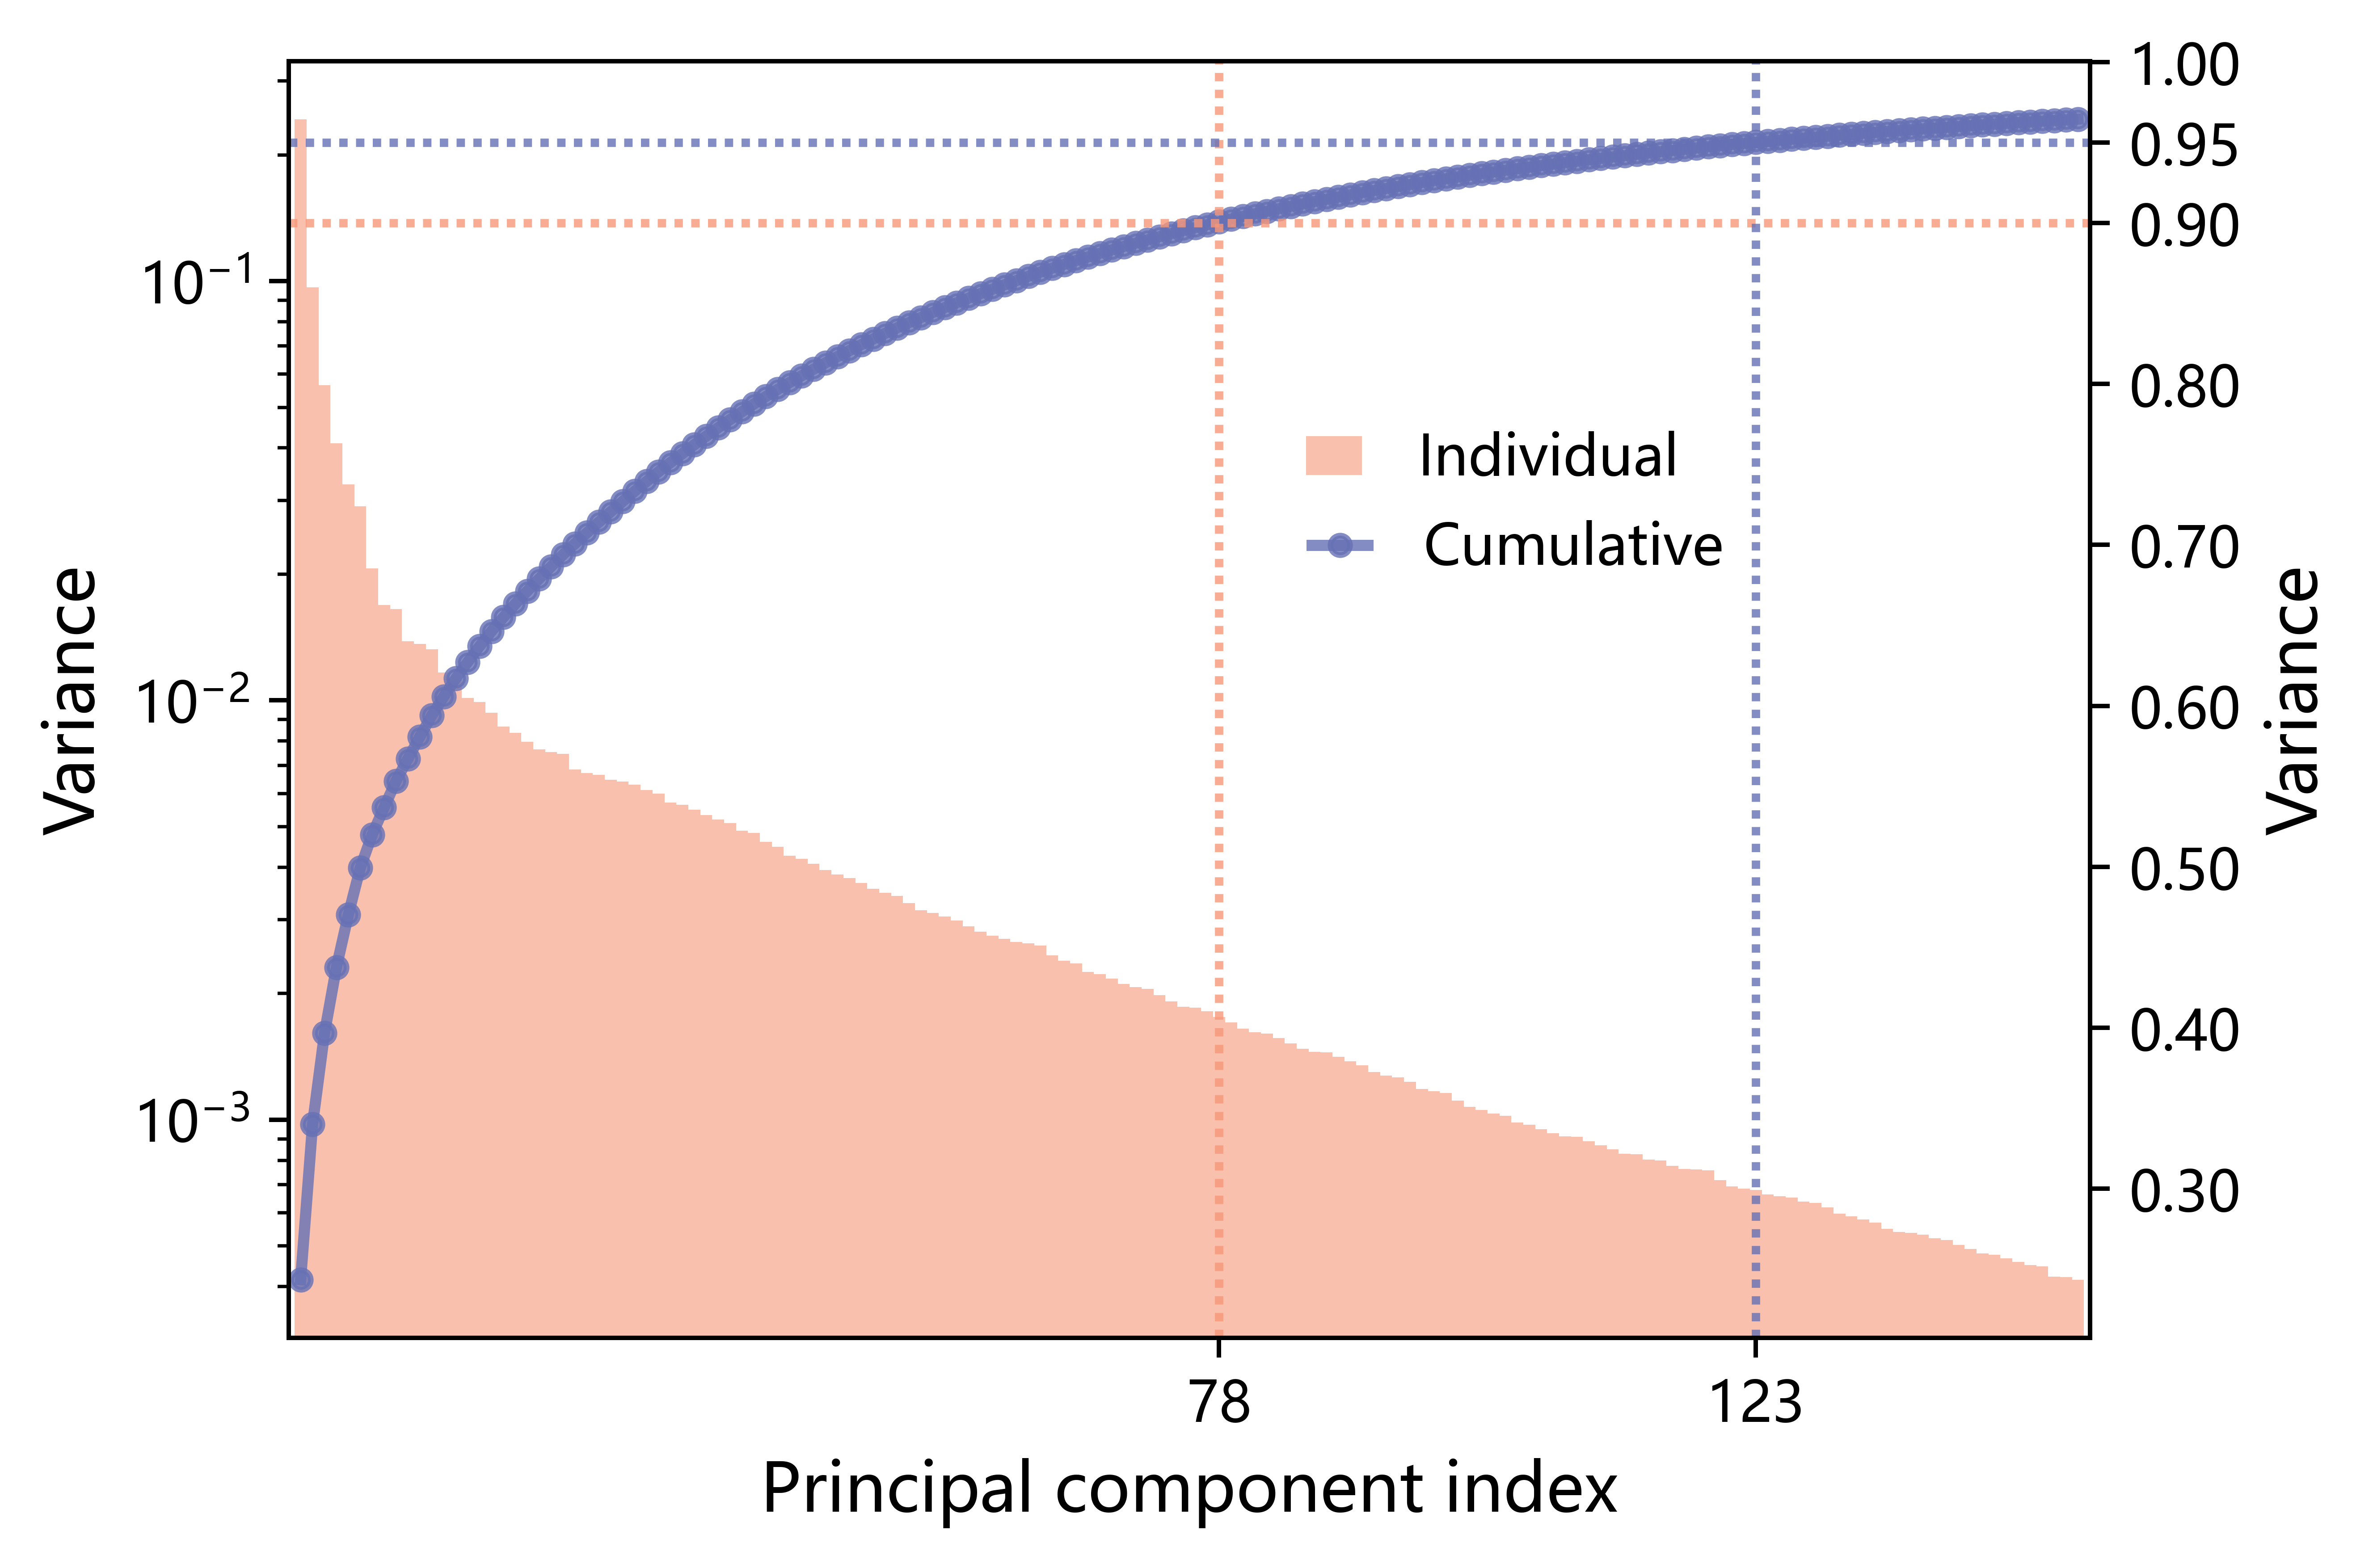

In [6]:
plt.rcParams['figure.dpi'] = 900
# 正则化数据
n = 150
colors = ['#6671b5', '#f79779']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(plot_PCA_train)
pca = PCA(n_components=n)
pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
value_90, value_95 = 0, 0
for i,cum in enumerate(cumulative_variance):
    if cum > 0.9:
        value_90 = i+1
        break
for i,cum in enumerate(cumulative_variance):
    if cum > 0.95:
        value_95 = i+1
        break
print(value_90, value_95)

plt.figure(figsize=(6, 4))
plt.yscale('log')
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, color=colors[1], width=1.0, label="Individual")
plt.xlabel("Principal component index", fontsize=12)
plt.ylabel("Variance", fontsize=12)
plt.xticks([value_90, value_95], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper right', bbox_to_anchor=(0.8, 0.75), frameon=False, fontsize=10, labelspacing=0.3, handletextpad=1, handlelength=1)

plt.twinx()
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='-', linewidth=2, markersize=3.5, color=colors[0], alpha=0.8, label="Cumulative")
plt.ylabel('Variance', fontsize=12)
plt.xlim(0, n+1)
plt.yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], fontsize=10)
plt.legend(loc='upper right', bbox_to_anchor=(0.825, 0.68), frameon=False, fontsize=10, labelspacing=0.3, handletextpad=1, handlelength=1)

plt.axhline(0.9, color='#f79779', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
plt.axvline(value_90, color='#f79779', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
plt.axhline(0.95, color='#6671b5', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
plt.axvline(value_95, color='#6671b5', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)

plt.tight_layout()  # 防止标签重叠

In [7]:
# 训练和测试集中属于0和1的类别有多少，做一个饼状图
# 再结合PCA降维，画一张图

from collections import Counter

# 统计元素个数
counter_train = Counter(y_train)
print(counter_train)
# 获取np.int64(0)对应的值
count_train_0 = counter_train[np.int64(0)]
print(count_train_0)
count_train_1 = counter_train[np.int64(1)]
print(count_train_1)

# 统计元素个数
counter_test = Counter(y_test)
print(counter_test)
count_test_0 = counter_test[np.int64(0)]
print(count_test_0)
count_test_1 = counter_test[np.int64(1)]
print(count_test_1)

[[count_train_1, count_train_0], [count_test_1, count_test_0]]

Counter({np.int64(1): 1622, np.int64(0): 1578})
1578
1622
Counter({np.int64(0): 422, np.int64(1): 378})
422
378


[[1622, 1578], [378, 422]]

[1622, 378] [1578, 422]


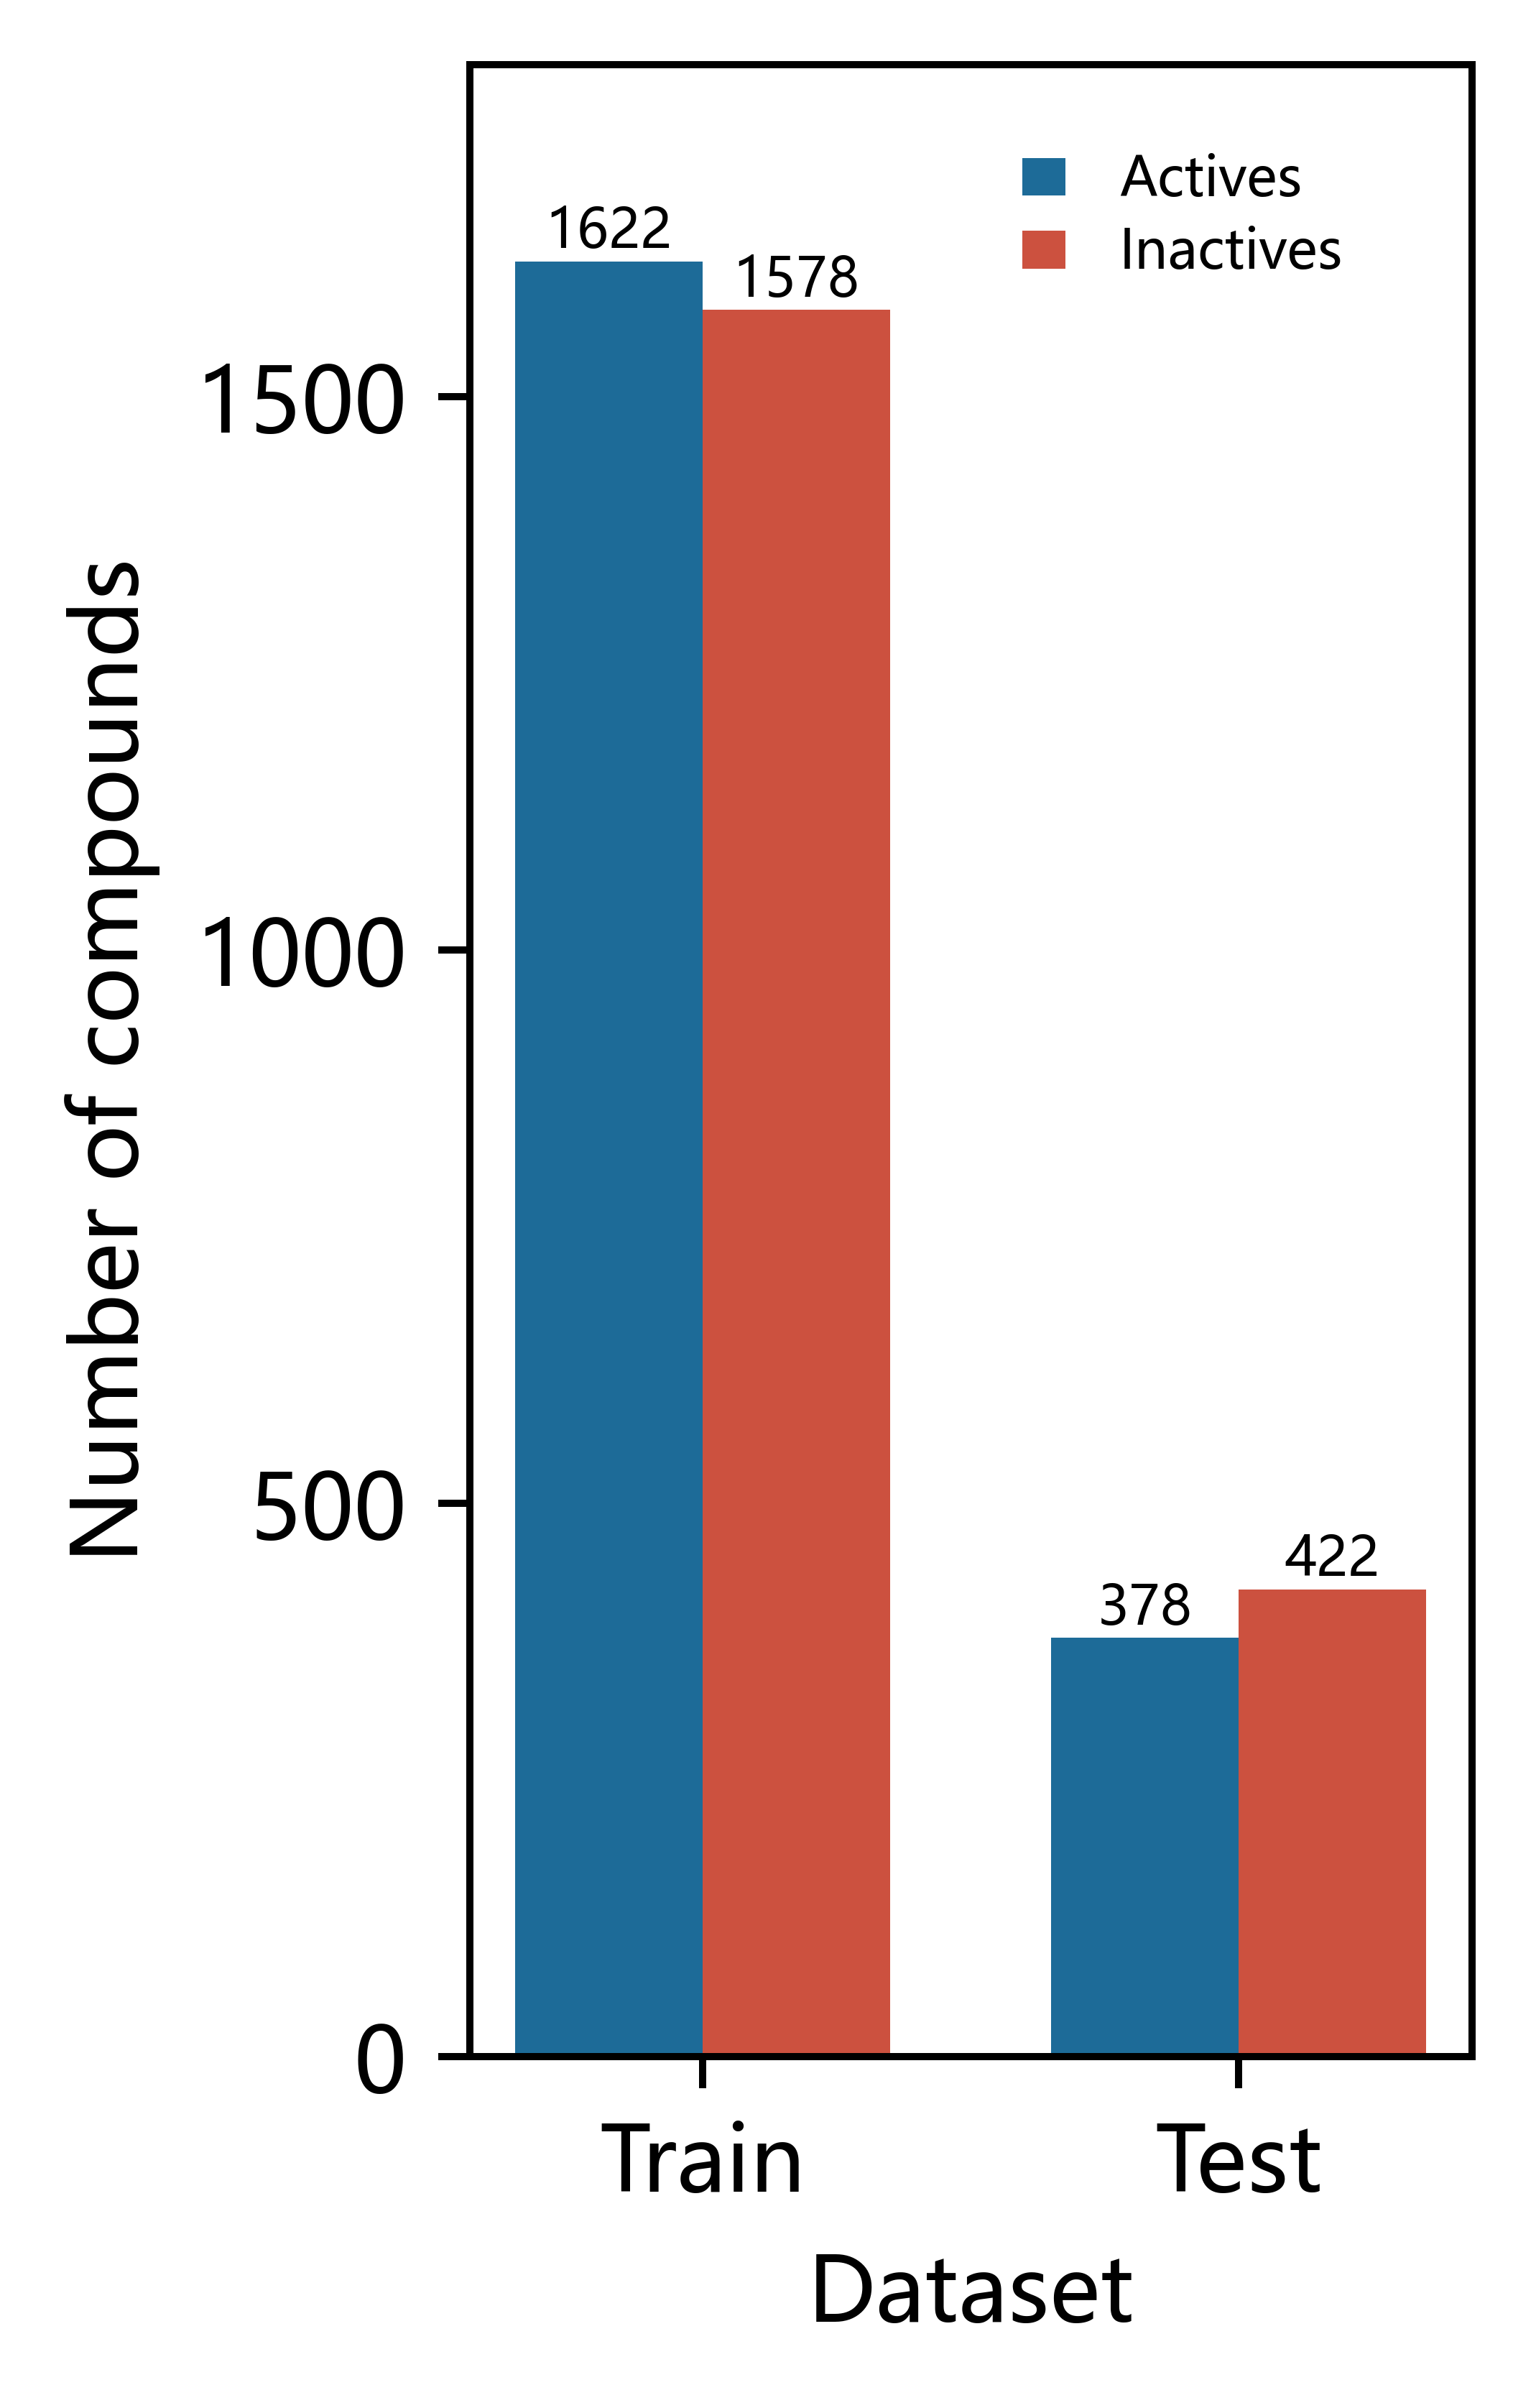

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 900

# 数据
data1 = [count_train_1, count_test_1]
data2 = [count_train_0, count_test_0]
categories = ['Train', 'Test']
print(data1, data2)
# 设置柱形的宽度
bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(2, 4))

bar1 = ax.bar(index, data1, bar_width, color='#1d6b98', label='Actives')
bar2 = ax.bar(index + bar_width, data2, bar_width, color='#cc513f', label='Inactives')


# 在柱形上方添加数值标签
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', 
                ha='center', va='bottom', fontsize=6)


ax.set_xlabel('Dataset')
ax.set_ylabel('Number of compounds')
ax.set_xticks(index + bar_width / 2)
ax.set_ylim(0, 1800)
ax.set_yticks([0, 500, 1000, 1500])
ax.set_xticklabels(categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.92, 0.98), frameon=False, fontsize=6, labelspacing=0.3, handletextpad=1, handlelength=0.8)

In [9]:
df_test_pred = pd.read_csv('./data/TP-2.csv')
# 检测索引是否有问题
# for i,ele in enumerate(df.columns[2:]):
#     index = list(df_test_pred.columns[2:]).index(ele)
#     if i != index:
#         print(i, index)

# 删除包含 NaN 的行
df_pred = df_test_pred.dropna()
df_values_pred = df_pred[df_pred.columns[2:]]
# print(df_values_pred.shape)
# classify_results = df_pred['type']
X_pred = df_values_pred.to_numpy()
print(X_pred.shape)
# y_pred_type = np.array(classify_results)
print(df_pred.iloc[:, :2])

X_pred_scaled = scaler.transform(X_pred)
X_test_pred = pca.transform(X_pred_scaled)
# print(len(X_test_pred))

(12, 1444)
   smiles  type
0     FIN     1
1      P1     1
2      P2     1
3      P3     1
4      P4     1
5      P5     1
6      P6     1
7      P7     1
8      P8     1
9      P9     1
10    P10     0
11    P11     0


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 创建 SVM 模型
svm_model = SVC(kernel='rbf', probability=True)  # 使用 RBF 核函数

# 训练模型
svm_model.fit(X_train, y_train)
print(svm_model)

SVC(probability=True)


In [11]:
def use_threshold_predict(model, X_train, optimal_threshold):
    # 使用最佳阈值进行分类
    y_train_prob = model.predict_proba(X_train)
    # 提取正类的概率
    positive_class_prob = y_train_prob[:, 1]
    y_pred_optimal = (positive_class_prob >= optimal_threshold).astype(int)
    # print(y_pred_optimal)
    return y_pred_optimal


optimal_threshold = 0.5
print('train.......')
y_train_pred = use_threshold_predict(svm_model, X_train, optimal_threshold)
get_results(y_train, y_train_pred)
print('test.......')
y_test_pred = use_threshold_predict(svm_model, X_test, optimal_threshold)
get_results(y_test, y_test_pred)

# 外部数据集的测试结果
y_target_pred = use_threshold_predict(svm_model, X_test_pred, optimal_threshold)
print(y_target_pred)
print(svm_model.predict_proba(X_test_pred))

train.......
Accuracy: 0.9844
Precision: 0.9810
Recall: 0.9883
F1 Score: 0.9846
AUC-ROC: 0.9843
test.......
Accuracy: 0.9600
Precision: 0.9529
Recall: 0.9630
F1 Score: 0.9579
AUC-ROC: 0.9602


ValueError: X has 150 features, but SVC is expecting 123 features as input.

#### 测试机样本分布

In [ ]:
# 预测概率
y_pred_prob = svm_model.predict_proba(X_test)  # 获取测试集的预测概率
# 选取真实标签为1的样本对应的预测概率
positive_class_prob = y_pred_prob[y_test == 1, 1]
print(positive_class_prob[:5])
# 选取真实标签为0的样本对应的预测概率
negative_class_prob = y_pred_prob[y_test == 0, 1]
print(negative_class_prob[:5])

[0.98657786 0.99999867 0.99409418 0.98854766 0.9525453 ]
[0.00314727 0.00037364 0.00310705 0.00027239 0.0146774 ]


#### 混淆矩阵

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

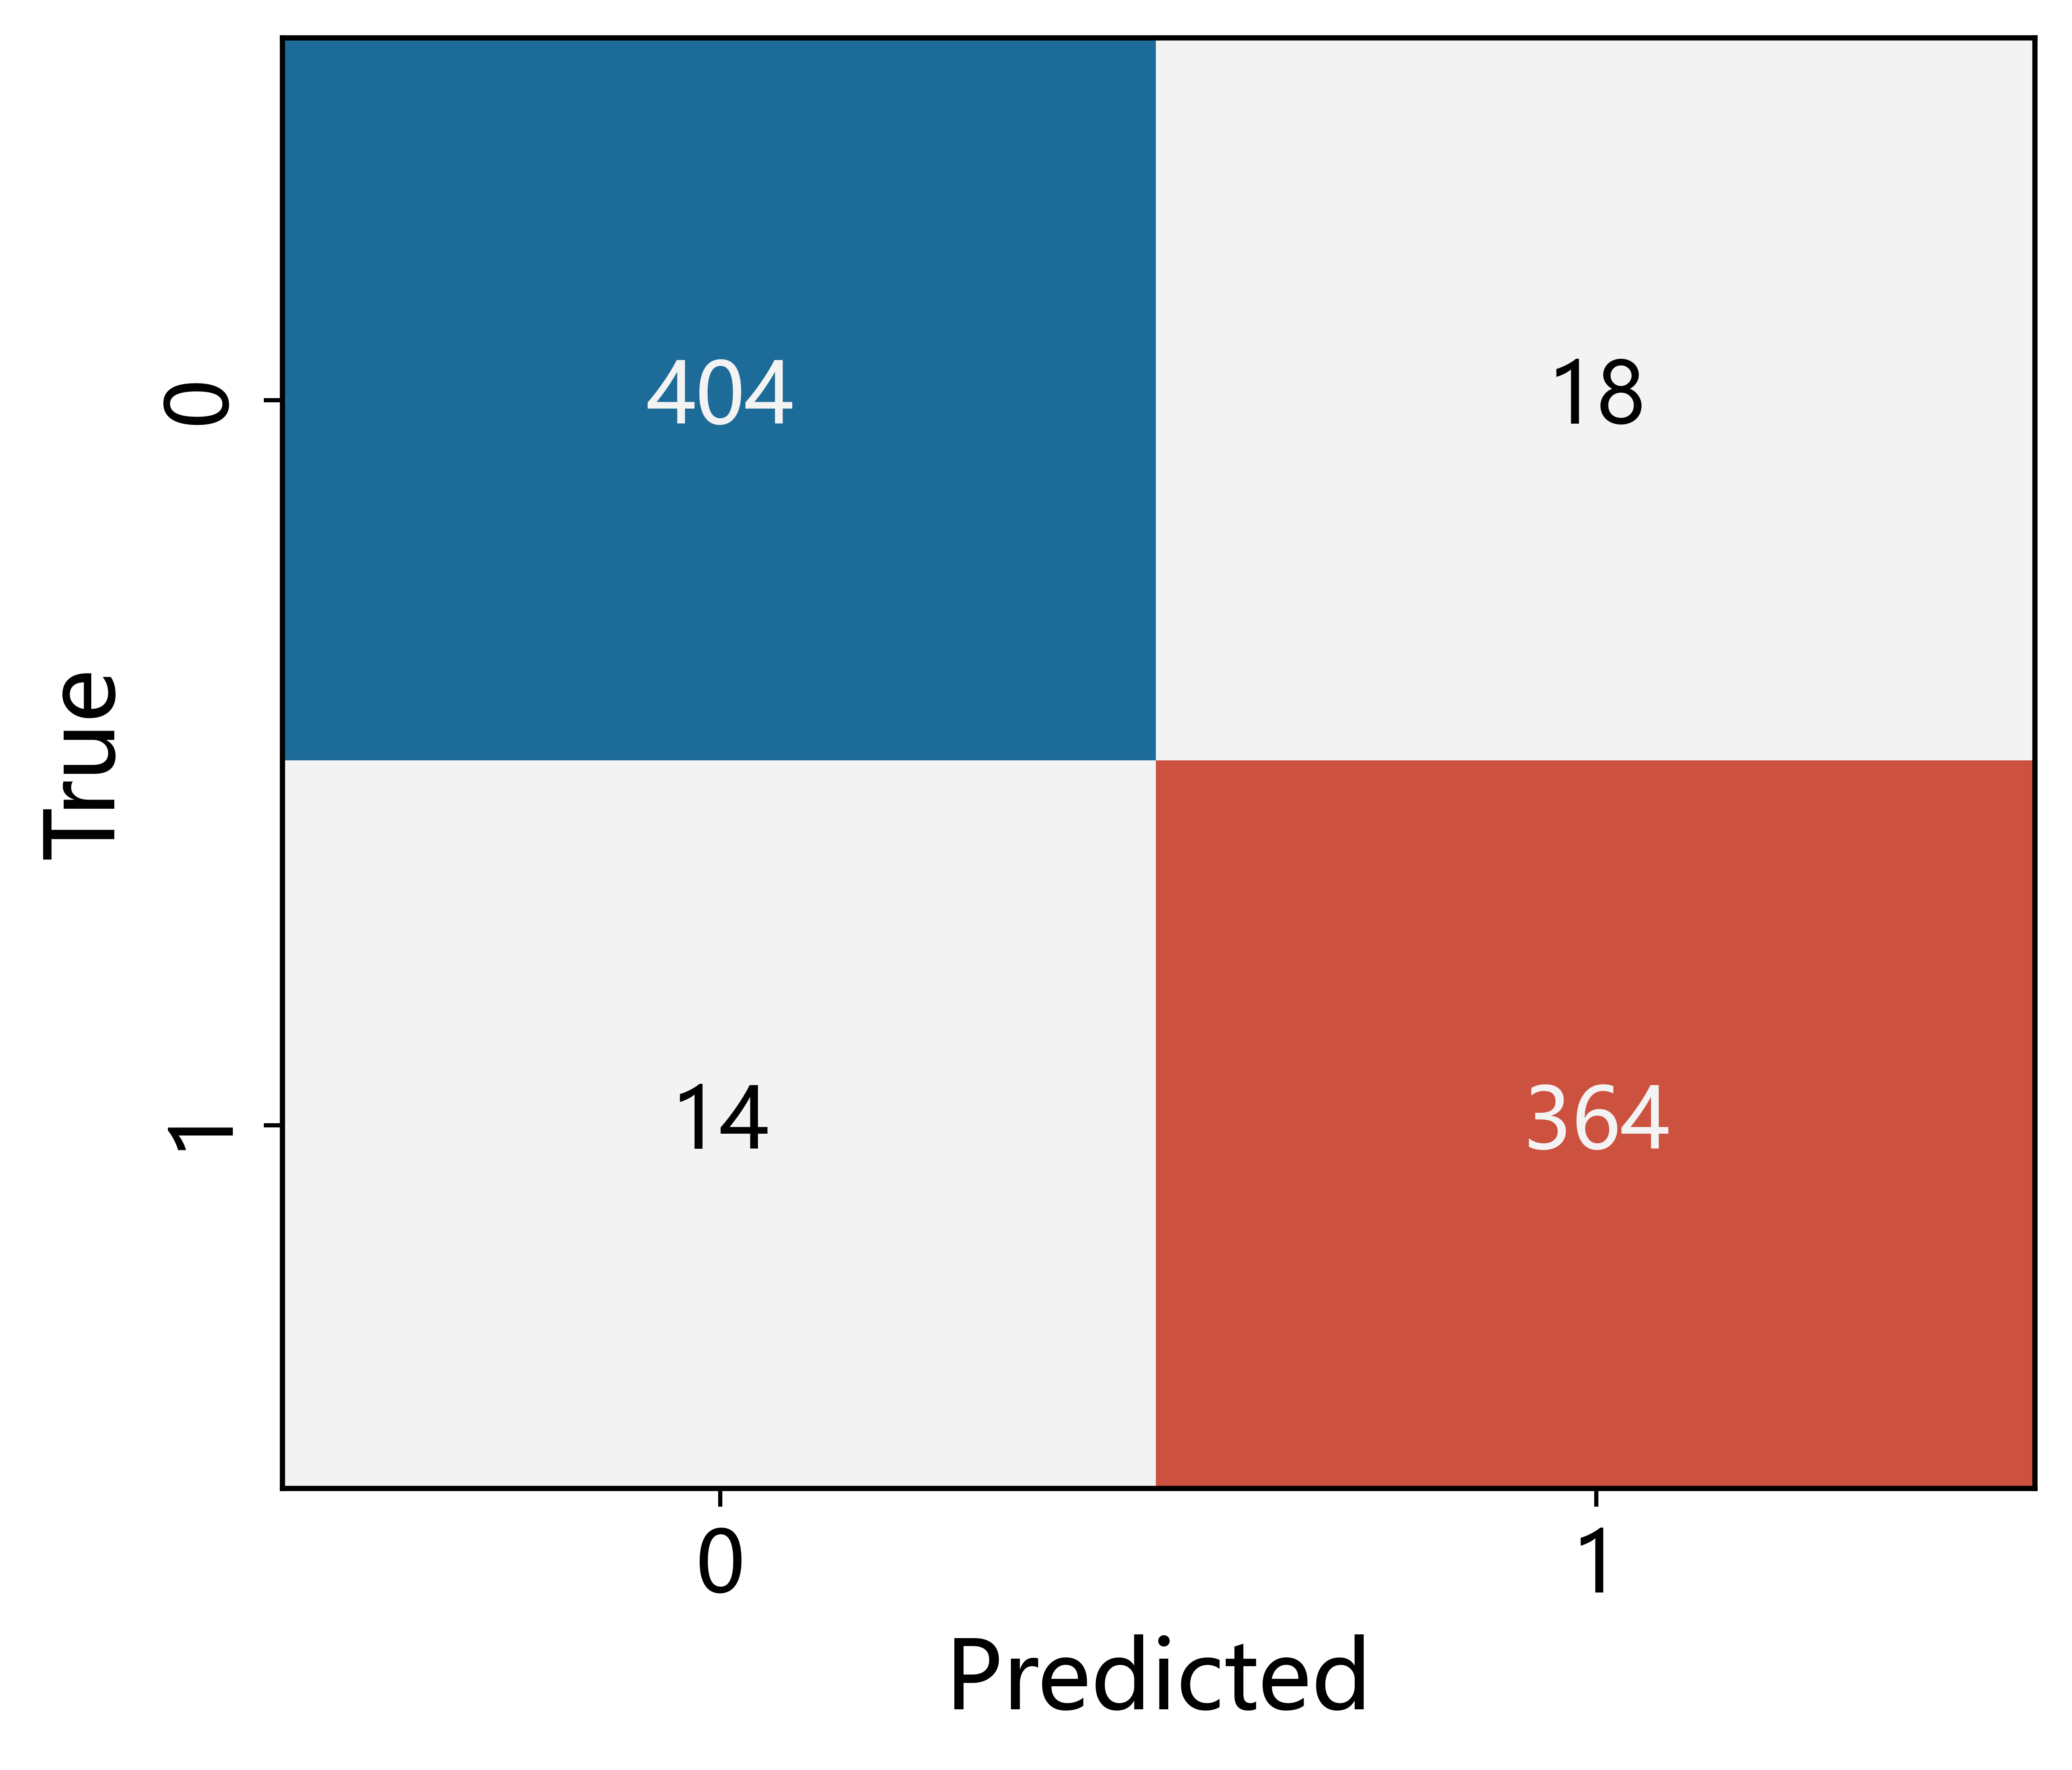

In [ ]:
from matplotlib.colors import ListedColormap
plt.rcParams['figure.dpi'] = 900

data = confusion_matrix(y_test, y_test_pred)
# 绘制热图
fig, ax = plt.subplots(figsize=(6, 5))  # 使用 subplots() 创建 fig 和 ax

sns.heatmap(data, annot=False, fmt='d', cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
# 仅添加外边框
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1)
plt.xlabel("Compounds")

cell_colors = np.array([['#1d6b98', '#f3f3f3'],['#f3f3f3', '#cc513f']])
font_colors = np.array([['#f3f3f3', 'black'],['black', '#f3f3f3']])
# 手动设置每个单元格的颜色
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color=cell_colors[i, j]))
        ax.text(j + 0.5, i + 0.5, f"{data[i, j]:.0f}", ha='center', va='center', color=font_colors[i, j], fontsize=16)


plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
# 设置坐标轴刻度字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#### 分类结果

Text(856.5, 0.5, 'Predicted')

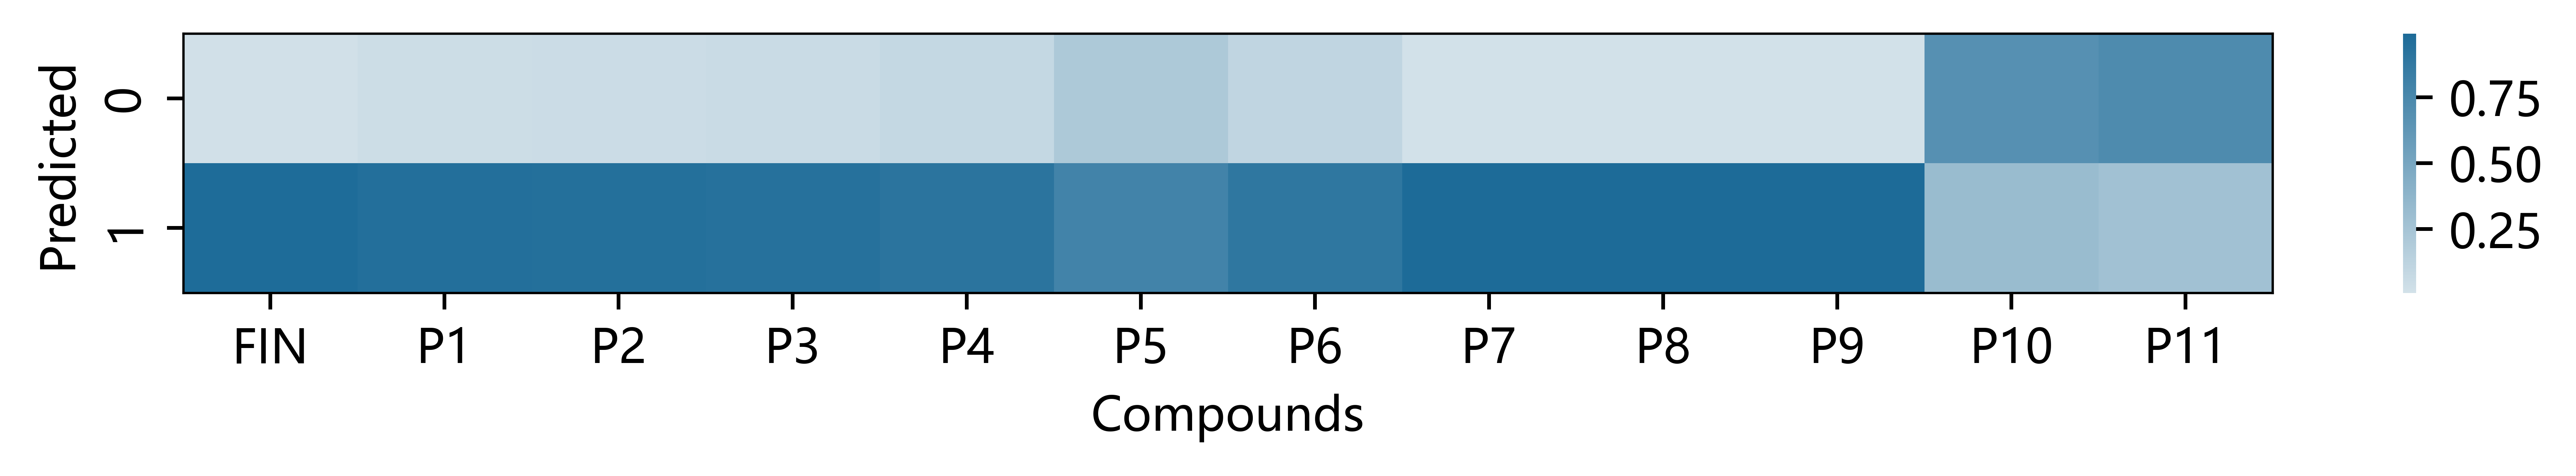

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['figure.dpi'] = 900

# print(svm_model.predict_proba(X_test_pred))
data = np.array(svm_model.predict_proba(X_test_pred))

data_reshaped = data.T
# 创建X轴标签
x_labels = list(df_test_pred['smiles'])
# 创建热力图
fig, ax = plt.subplots(figsize=(10, 1))  # 使用 subplots() 创建 fig 和 ax
color_range = ['#d2e1e9', '#1d6b98']
# 定义一个自定义的渐变色
deep_cmap = LinearSegmentedColormap.from_list('deep_blue_cmap', color_range)
color = deep_cmap
sns.heatmap(
    data_reshaped,
    annot=False,
    fmt=".4f",
    cmap=color,
    cbar=True,
    linewidths=0,
    xticklabels=x_labels,  # 设置X轴标签
    yticklabels=["0", "1"]  # 设置Y轴标签
)
# 仅添加外边框
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(0.5)
plt.xlabel("Compounds")
plt.ylabel("Predicted")

#### AUC

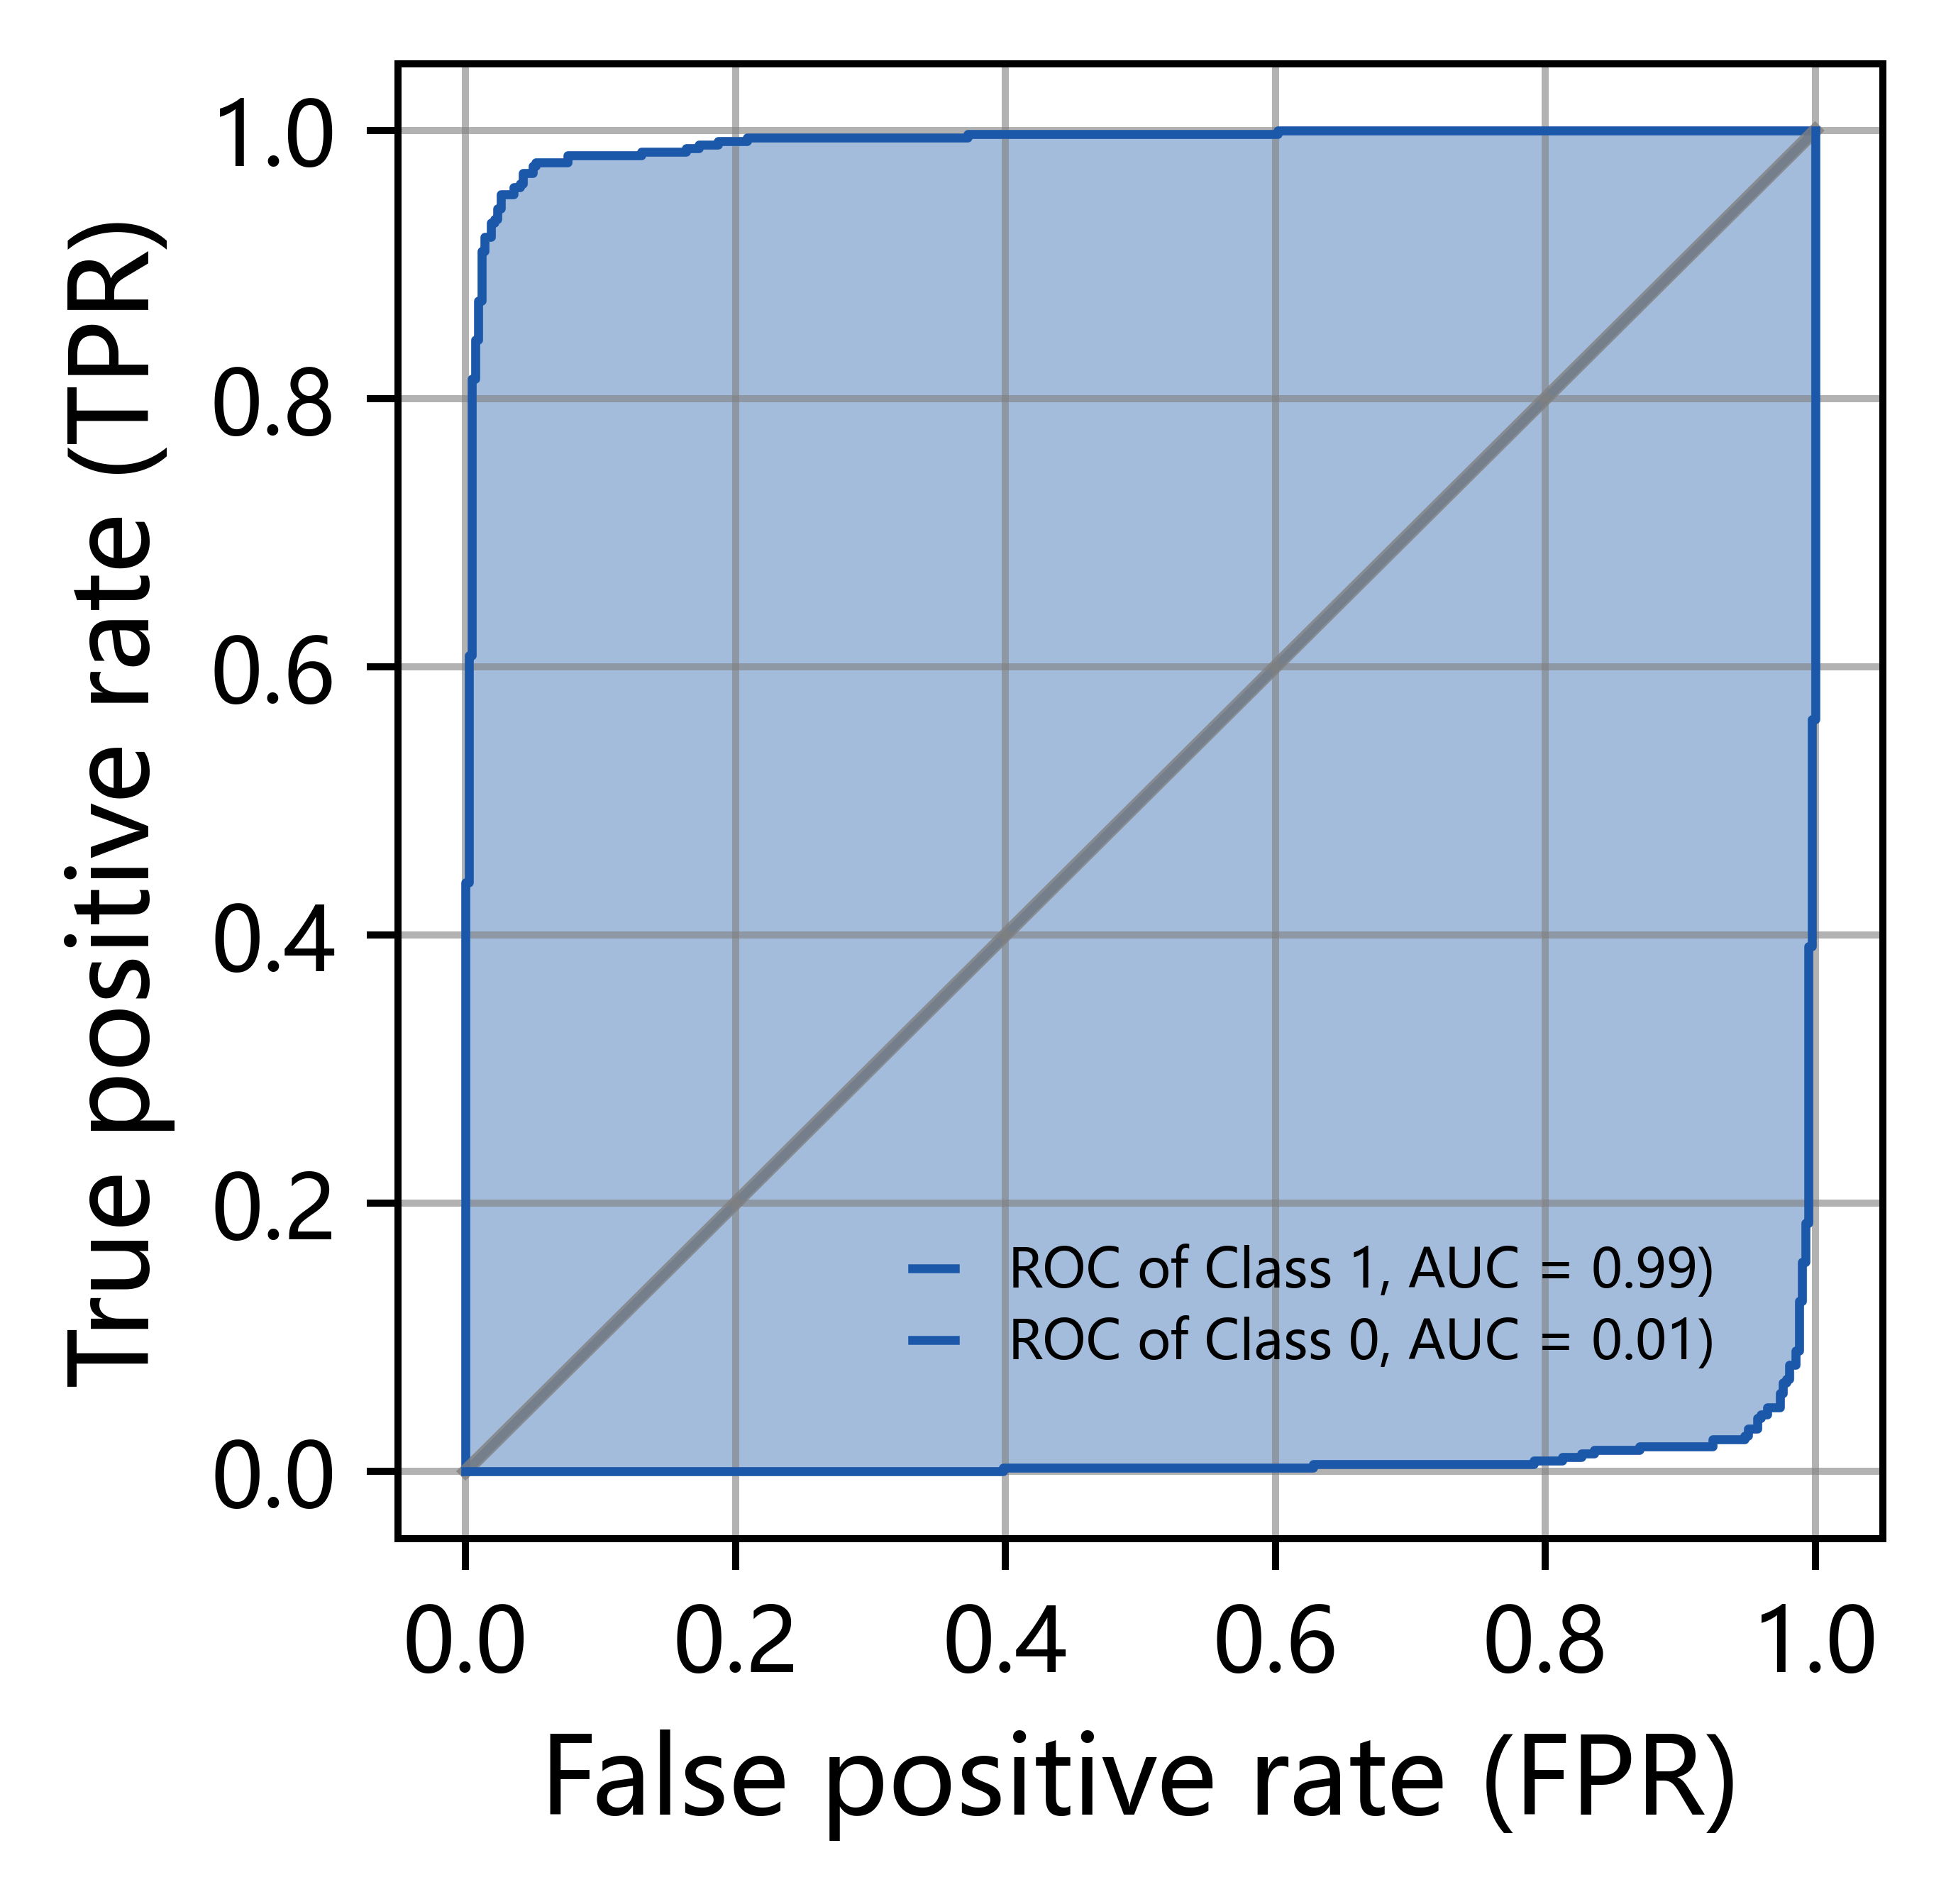

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
plt.rcParams['figure.dpi'] = 900

plt.figure(figsize=(3, 3))

# 正类的概率
y_postitive_score = svm_model.predict_proba(X_test)[:, 1]  # 获取正类的概率
postitive_fpr, postitive_tpr, _ = roc_curve(y_test, y_postitive_score)
postitive_roc_auc = auc(postitive_fpr, postitive_tpr)
plt.plot(postitive_fpr, postitive_tpr, color='#1c58a9', linewidth=1, label=f'ROC of Class 1, AUC = {postitive_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linewidth=1.5, alpha=0.8)  # 对角线（随机分类器）

# 填充正类 ROC 曲线与对角线之间的区域
plt.fill_between(postitive_fpr, postitive_tpr, postitive_fpr, color='#1c58a9', alpha=0.4)

# 负类的概率
y_negative_score = svm_model.predict_proba(X_test)[:, 0]
negative_fpr, negative_tpr, _ = roc_curve(y_test, y_negative_score)
negative_roc_auc = auc(negative_fpr, negative_tpr)
plt.plot(negative_fpr, negative_tpr, color='#1c58a9', linewidth=1, label=f'ROC of Class 0, AUC = {negative_roc_auc:.2f})')

# 填充负类 ROC 曲线与对角线之间的区域
plt.fill_between(negative_fpr, negative_tpr, negative_fpr, color='#1c58a9', alpha=0.4)


plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate (FPR)', fontsize=12)
plt.ylabel('True positive rate (TPR)', fontsize=12)
plt.legend(loc='lower right', bbox_to_anchor=(0.92, 0.08), frameon=False, fontsize=6, labelspacing=0.3, handletextpad=1, handlelength=0.8)
plt.grid(color='gray', alpha=0.6)

#### 绘制总图

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
def plotPanelA(ax):    
    # 数据
    data1 = [count_train_1, count_test_1]
    data2 = [count_train_0, count_test_0]
    categories = ['Train', 'Test']
    # print(data1, data2)
    # 设置柱形的宽度
    bar_width = 0.35
    index = np.arange(len(categories))
    bar1 = ax.bar(index, data1, bar_width, color='#1d6b98', label='1')
    bar2 = ax.bar(index + bar_width, data2, bar_width, color='#cc513f', label='0')
    # 在柱形上方添加数值标签
    for bars in [bar1, bar2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', 
                    ha='center', va='bottom', fontsize=6)

    ax.set_xlabel('Dataset', fontsize=10)
    ax.set_ylabel('Number of compounds', fontsize=10)
    ax.set_xticks(index + bar_width / 2)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylim(0, 1800)
    ax.set_yticks([0, 500, 1000, 1500])
    ax.set_xticklabels(categories)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 0.88), frameon=False, fontsize=8, labelspacing=0.3, handletextpad=1, handlelength=0.8)


def plotPanelB(ax, fig):
    # 正则化数据
    n = 150
    # colors = ['#6671b5', '#f79779']
    colors = ['#1d6b98', '#cc513f']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(plot_PCA_train)
    pca = PCA(n_components=n)
    pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    value_90, value_95 = 0, 0
    for i,cum in enumerate(cumulative_variance):
        if cum > 0.9:
            value_90 = i+1
            break
    for i,cum in enumerate(cumulative_variance):
        if cum > 0.95:
            value_95 = i+1
            break
    # print(value_90, value_95)
    ax.set_yscale('log')
    ax.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, color=colors[1], width=1.0, label="Individual")
    ax.set_xlabel("Principal component index", fontsize=10)
    ax.set_ylabel("Variance", fontsize=10)
    ax.set_xticks([value_90, value_95])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(loc='upper right', bbox_to_anchor=(0.8, 0.75), frameon=False, fontsize=8, labelspacing=0.3, handletextpad=1, handlelength=1)

    ax1 = ax.twinx()
    ax1.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='-', linewidth=2, markersize=3.5, color=colors[0], alpha=0.8, label="Cumulative")
    ax1.set_ylabel('Variance', fontsize=10)
    ax1.set_xlim(0, n+1)
    ax1.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1])
    ax1.tick_params(axis='y', labelsize=8)
    ax1.legend(loc='upper right', bbox_to_anchor=(0.825, 0.68), frameon=False, fontsize=8, labelspacing=0.3, handletextpad=1, handlelength=1)
    
    ax1.axhline(0.9, color='#1d6b98', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
    ax1.axvline(value_90, color='#1d6b98', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
    ax1.axhline(0.95, color='#cc513f', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
    ax1.axvline(value_95, color='#cc513f', linewidth=1.5, linestyle='--', dashes=(1, 1), alpha=0.8)
    fig.tight_layout()  # 防止标签重叠


def plotPanelC(ax):
    # 正类的概率
    y_postitive_score = svm_model.predict_proba(X_test)[:, 1]  # 获取正类的概率
    postitive_fpr, postitive_tpr, _ = roc_curve(y_test, y_postitive_score)
    postitive_roc_auc = auc(postitive_fpr, postitive_tpr)
    ax.plot(postitive_fpr, postitive_tpr, color='#1c58a9', linewidth=1, label=f'ROC curve (AUC = {postitive_roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linewidth=1.5, alpha=0.8)  # 对角线（随机分类器）

    # 填充正类 ROC 曲线与对角线之间的区域
    ax.fill_between(postitive_fpr, postitive_tpr, postitive_fpr, color='#1c58a9', alpha=0.4)
    # 负类的概率
    y_negative_score = svm_model.predict_proba(X_test)[:, 0]
    negative_fpr, negative_tpr, _ = roc_curve(y_test, y_negative_score)
    negative_roc_auc = auc(negative_fpr, negative_tpr)
    ax.plot(negative_fpr, negative_tpr, color='#1c58a9', linewidth=1, label=f'ROC curve (AUC = {negative_roc_auc:.2f})')
    # 填充负类 ROC 曲线与对角线之间的区域
    ax.fill_between(negative_fpr, negative_tpr, negative_fpr, color='#1c58a9', alpha=0.4)

    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel('False positive rate (FPR)', fontsize=10)
    ax.set_ylabel('True positive rate (TPR)', fontsize=10)
    # plt.legend(loc='lower right')
    ax.grid(color='gray', alpha=0.6)


def plotPanelD(ax):
    box = ax.get_position()
    ax.set_position([box.x0 + box.width * 0.1, box.y0 + box.height * 0.1, box.width * 0.8, box.height * 0.8])
    data = confusion_matrix(y_test, y_test_pred)
    map = sns.heatmap(ax=ax, data=data, annot=False, fmt='d', cbar=False, xticklabels=['0', '1'], yticklabels=['0', '1'])
    # 仅添加外边框
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color("black")
        spine.set_linewidth(1)
    ax.set_xlabel("Compounds")
    cell_colors = np.array([['#1d6b98', '#f3f3f3'],['#f3f3f3', '#cc513f']])
    font_colors = np.array([['#f3f3f3', 'black'],['black', '#f3f3f3']])
    # 手动设置每个单元格的颜色
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=cell_colors[i, j]))
            ax.text(j + 0.5, i + 0.5, f"{data[i, j]:.0f}", ha='center', va='center', color=font_colors[i, j], fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    # 设置坐标轴刻度字体大小
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    

def plotPanelE(ax):
    data = np.array(svm_model.predict_proba(X_test_pred))
    data_reshaped = data.T
    # 创建X轴标签
    x_labels = list(df_test_pred['smiles'])
    color_range = ['#d2e1e9', '#1d6b98']
    # 定义一个自定义的渐变色
    deep_cmap = LinearSegmentedColormap.from_list('deep_blue_cmap', color_range)
    color = deep_cmap
    map = sns.heatmap(
        ax=ax,
        data = data_reshaped,
        annot=False,
        fmt=".4f",
        cmap=color,
        cbar=False,
        linewidths=0,
        xticklabels=x_labels,  # 设置X轴标签
        yticklabels=["0", "1"]  # 设置Y轴标签
    )
    # 仅添加外边框
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color("black")
        spine.set_linewidth(1)
    ax.set_xlabel("Compounds", fontsize=10)
    ax.set_ylabel("Predicted", fontsize=10)

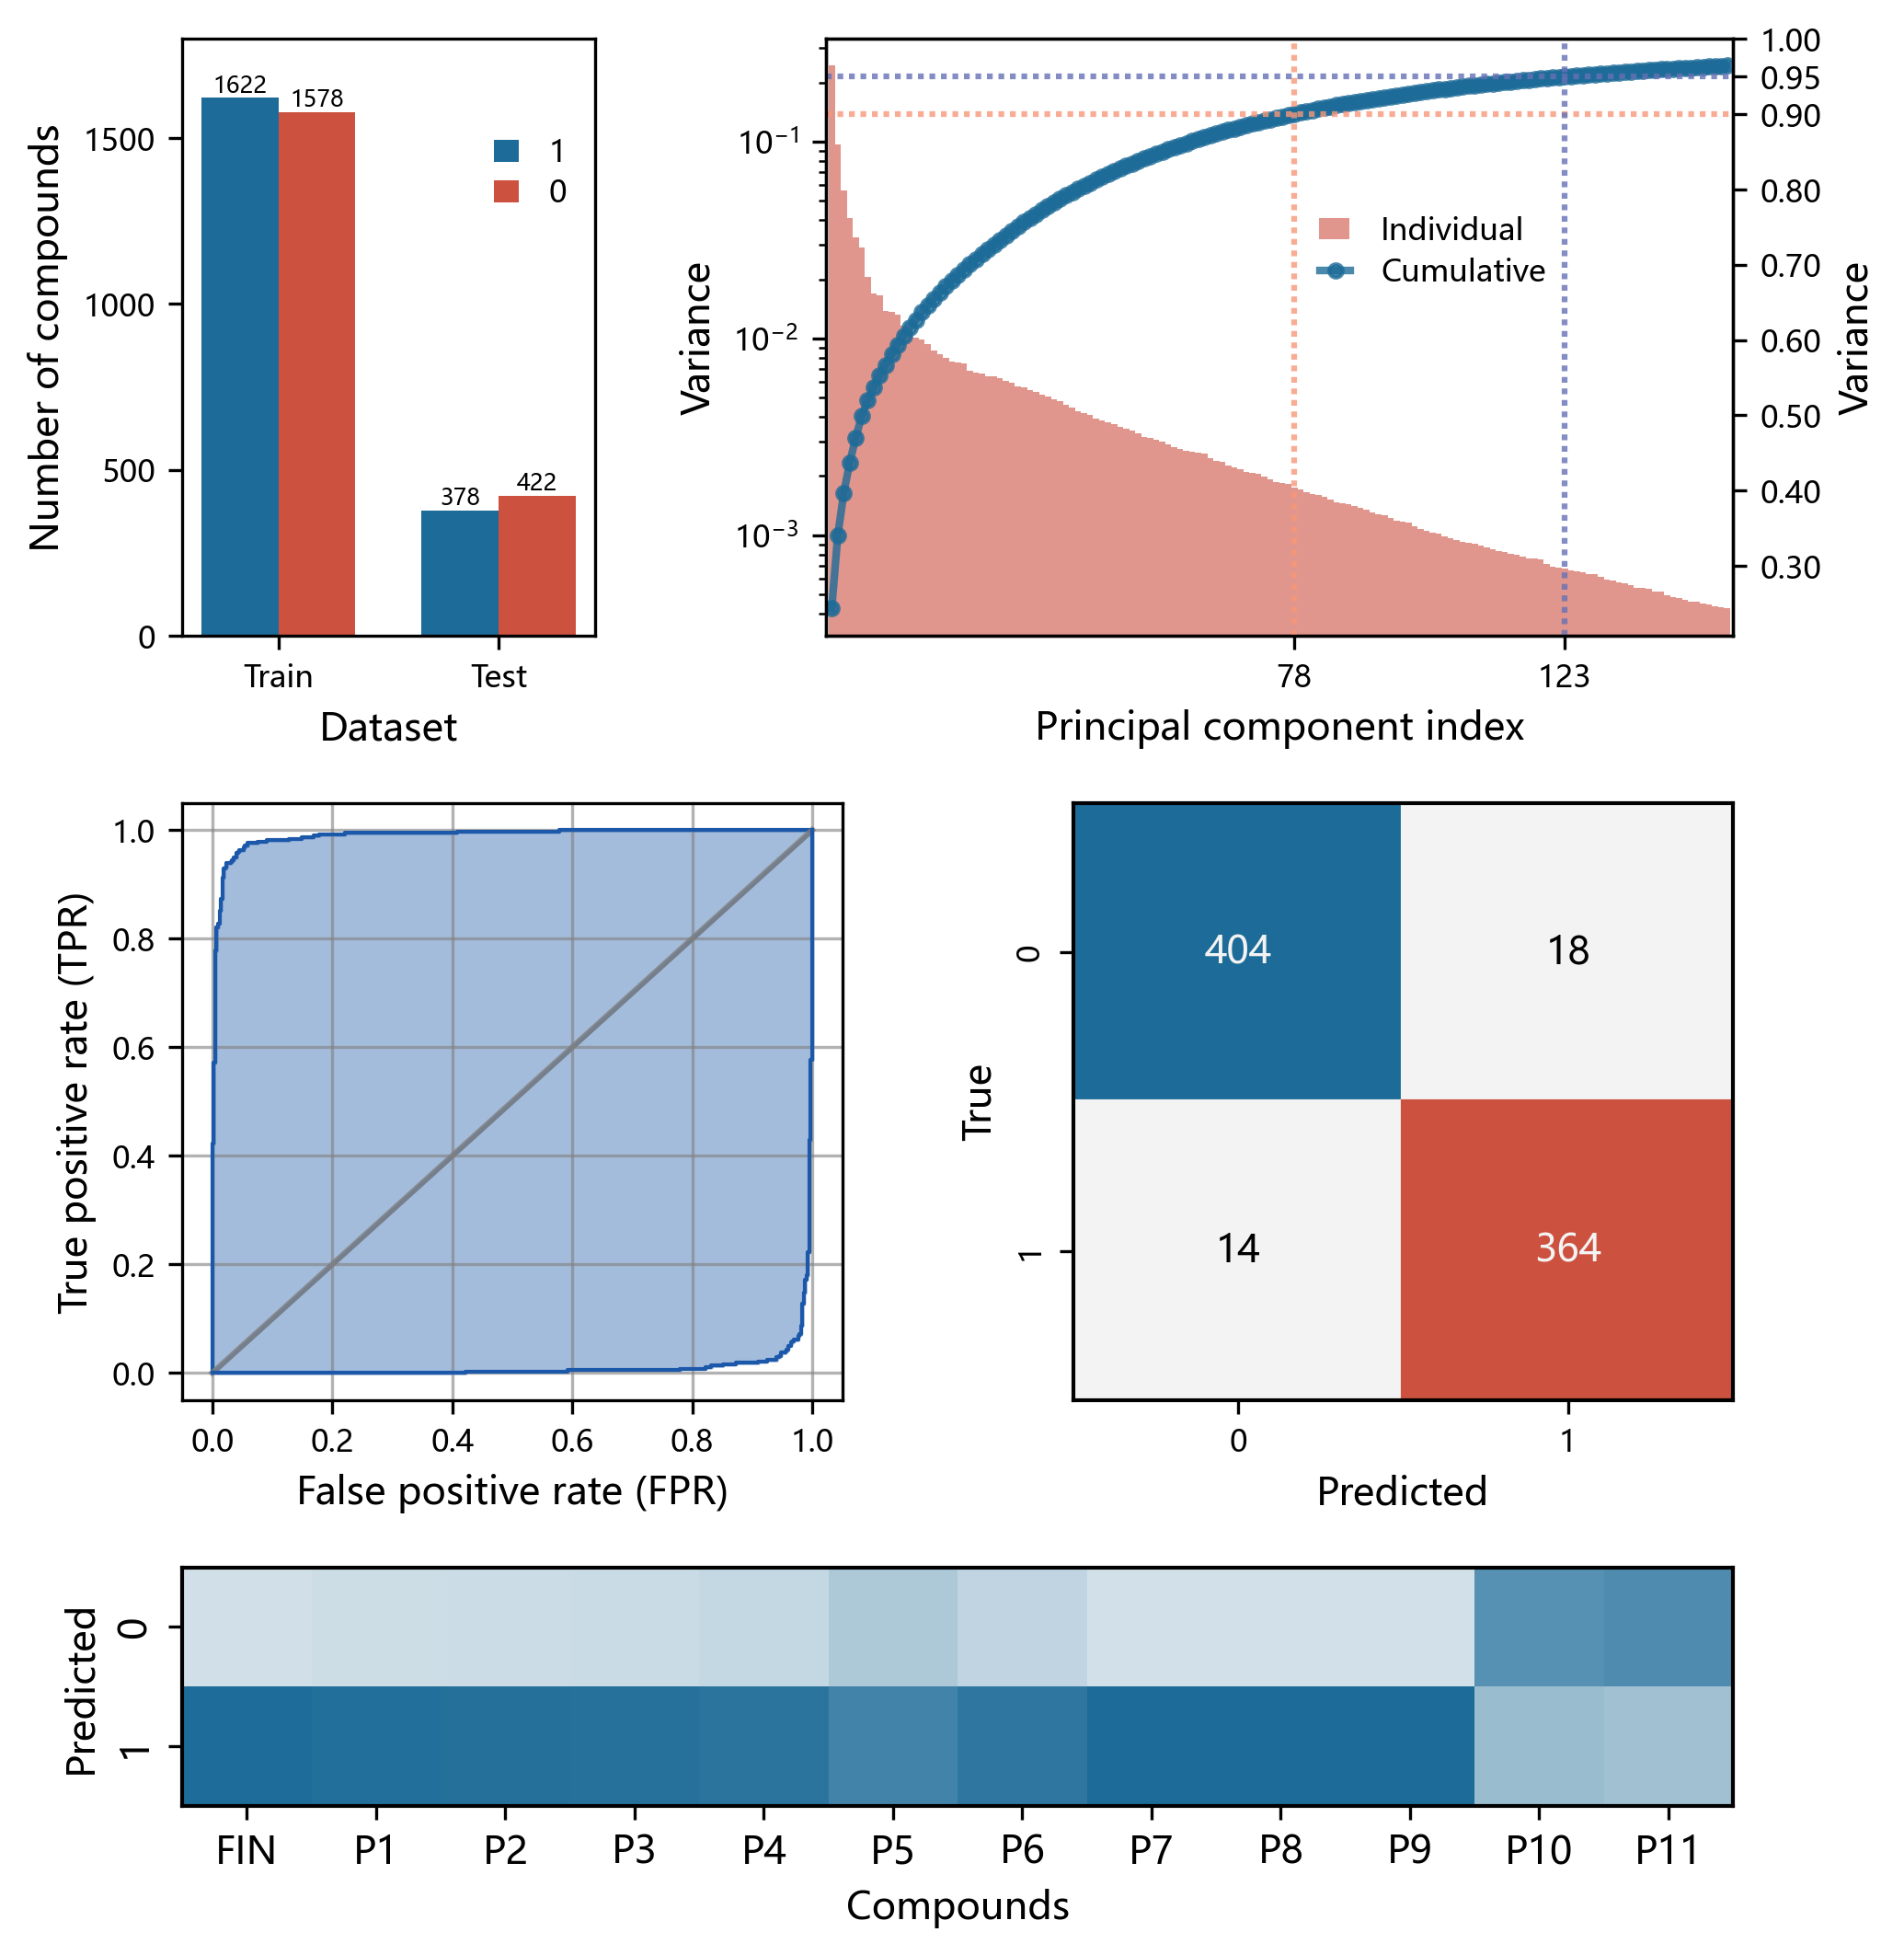

In [ ]:
# 删除边框和标签
def delBorder(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])


plt.rcParams['figure.dpi'] = 300
fig, axs_total = plt.subplots(3, 1, figsize=(7, 7), gridspec_kw={'height_ratios': [3, 3, 1.2]})

# 绘制子图 A B
axs_AB = axs_total[0]
inner_grids_AB = axs_AB.get_subplotspec().subgridspec(1, 2, width_ratios=[1, 2.2], wspace=0.35)
# 子图 A
axA = fig.add_subplot(inner_grids_AB[0, 0])
plotPanelA(axA)
# 子图 B
axB = fig.add_subplot(inner_grids_AB[0, 1])
plotPanelB(axB, fig)

delBorder(axs_AB)


# 绘制子图 C D
axs_CD = axs_total[1]
inner_grids_CD = axs_CD.get_subplotspec().subgridspec(1, 2, width_ratios=[1, 1], wspace=0.35)
# 子图 C
axC = fig.add_subplot(inner_grids_CD[0, 0])
plotPanelC(axC)
# 子图 D
axD = fig.add_subplot(inner_grids_CD[0, 1])
plotPanelD(axD)

delBorder(axs_CD)


# 绘制子图 E
axE = axs_total[2]
plotPanelE(axE)

fig.subplots_adjust(wspace=0, hspace=0.35)

# # 添加字母
# fig.text(0.07, 0.912, 'A', fontsize=20, va='top', fontweight='bold')
# fig.text(0.6, 0.912, 'B', fontsize=20, va='top', fontweight='bold')